In [12]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from spikingjelly0.spikingjelly.activation_based import neuron, functional, layer, surrogate
import matplotlib.pyplot as plt
import numpy as np

# Some simple neuron testing
primarily showing how inference (input/output mechanics of neuron) works, e.g., examining connectivity: one-to-one or recurrent (convolutional, fully connected, etc.)

using a LIF neuron

In [13]:
# neuron
lif = neuron.LIFNode(tau=10.)
# timesteps
T = 100

# testing nothing
zero= torch.zeros(5, 5)
print(f'neuron voltage before nothing: {lif.v}')
lif(zero)
print(f'neuron voltage after nothing:\n{lif.v}')

print()

#testing neuron activation given single stimulus
lif.reset()
one = torch.zeros(5, 5)
one[2, 2] = 1
print(f'input with only one one:\n{one}')
print(f'neuron voltage before one: {lif.v}')
lif(one)
print(f'neuron voltage after one:\n{lif.v}')

print()

# resest test
lif.reset()
print(f'neuron voltage after being reset:\n{lif.v}')


neuron voltage before nothing: 0.0
neuron voltage after nothing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

input with only one one:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
neuron voltage before one: 0.0
neuron voltage after one:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

neuron voltage after being reset:
0.0


In [14]:
# testing more stimuli
lif.reset()
nine = torch.zeros(5, 5)
nine[1:4, 1:4] = 1
print(f'input with only nine ones:\n{nine}')
print(f'neuron voltage before one: {lif.v}')
lif(nine)
print(f'neuron voltage after one:\n{lif.v}')

input with only nine ones:
tensor([[0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]])
neuron voltage before one: 0.0
neuron voltage after one:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.1000, 0.1000, 0.0000],
        [0.0000, 0.1000, 0.1000, 0.1000, 0.0000],
        [0.0000, 0.1000, 0.1000, 0.1000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


note: seems that there is no recurrent behavior by default
will try adding recurrent behavior and see what happens

## A quick test of spikingjelly.visualizing

In [15]:
from spikingjelly import visualizing
import math

In [16]:
stimulus = nine[:, 2].unsqueeze(0)
print(stimulus)
stimulus2 = torch.zeros(stimulus.shape)
stimulus2[0, 2] = 1
print(stimulus2)
zero_stimulus = zero[:, 2].unsqueeze(0)
print(zero_stimulus)

tensor([[0., 1., 1., 1., 0.]])
tensor([[0., 0., 1., 0., 0.]])
tensor([[0., 0., 0., 0., 0.]])


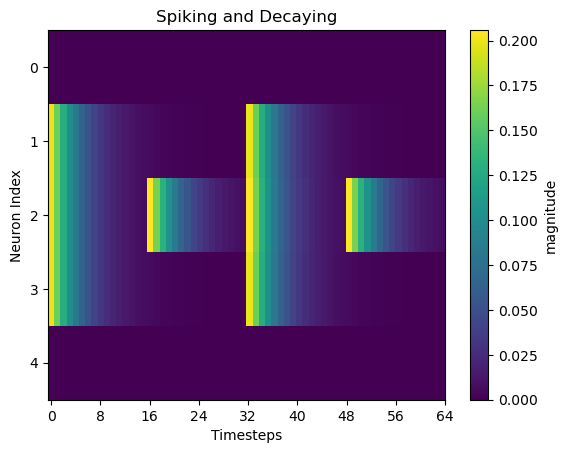

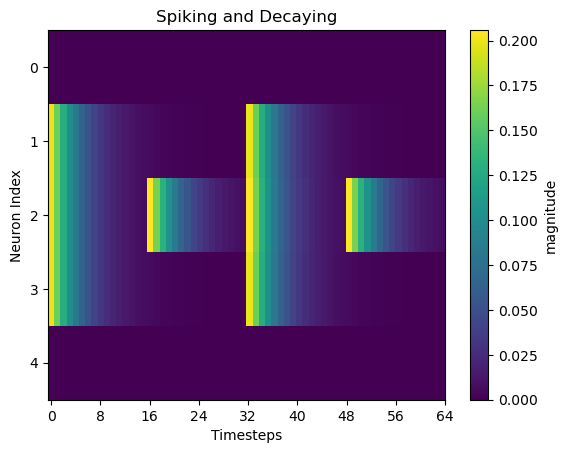

In [17]:
lif = neuron.LIFNode(tau=5.)
T = 64
voltages = []
for t in range(T):
  if t % math.floor(T/2) == 0:
    lif(stimulus)
  elif t % math.floor(T/4) == 0:
    lif(stimulus2)
  else:
    lif(zero_stimulus)
  voltages.append(lif.v)

voltages = torch.cat(voltages)

visualizing.plot_2d_heatmap(array=voltages, title='Spiking and Decaying', xlabel='Timesteps', ylabel='Neuron Index', int_x_ticks=True, x_max=T, dpi=100)

## Recurrent neurons

### Element-Wise Recurrence
At each time step, the neuron is fed the current input and its previous state, which are acted on by the element_wise_function

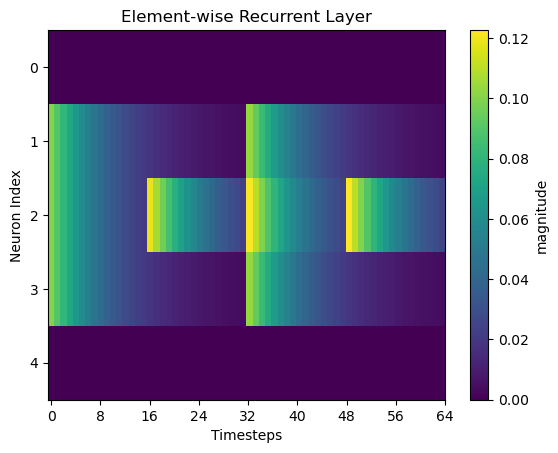

In [18]:
# adding previous hidden state to current state input
element_wise_add = lambda x, y : x + y
elt_recurrent_lif = layer.ElementWiseRecurrentContainer(neuron.LIFNode(10.), element_wise_function=element_wise_add)

T = 64
elt_voltages = []

with torch.no_grad():
  for t in range(T):
    if t % math.floor(T/2) == 0:
      elt_recurrent_lif(stimulus)
    elif t % math.floor(T/4) == 0:
      elt_recurrent_lif(stimulus2)
    else:
      elt_recurrent_lif(zero_stimulus)
    elt_voltages.append(elt_recurrent_lif.sub_module.v)

  elt_voltages = torch.cat(elt_voltages)

  visualizing.plot_2d_heatmap(array=elt_voltages, title='Element-wise Recurrent Layer', xlabel='Timesteps', ylabel='Neuron Index', int_x_ticks=True, x_max=T, dpi=100)

### Linear (Matrix) Recurrence
At each time step, the neuron is fed the current input and its previous state, which are acted on by the element_wise_function

Note: only using a single input in single_stimulus

In [19]:
num_features = 5
lin_recurrent_lif1 = layer.LinearRecurrentContainer(neuron.LIFNode(tau=4.), in_features=num_features, out_features=num_features, bias=False)
lin_recurrent_lif2 = layer.LinearRecurrentContainer(neuron.LIFNode(tau=8.), in_features=num_features, out_features=num_features, bias=False)

single_stimulus = torch.zeros(num_features).unsqueeze(dim=0)
single_stimulus[:, math.floor(num_features / 2)] = 1
print(single_stimulus)

tensor([[0., 0., 1., 0., 0.]])


Weights of Linear Recurrent Layer 1:
[[-0.139 -0.034  0.164  0.238 -0.309  0.197 -0.045 -0.097 -0.077 -0.167]
 [-0.147 -0.277 -0.225 -0.222 -0.218 -0.24  -0.253 -0.158  0.011  0.165]
 [ 0.098 -0.315  0.075  0.001 -0.221 -0.277 -0.124 -0.094 -0.296  0.162]
 [-0.089  0.086 -0.255  0.207  0.278  0.199  0.148 -0.057  0.052  0.099]
 [ 0.244  0.022  0.24  -0.082  0.01   0.008 -0.3   -0.291  0.13   0.045]]
Weights of Linear Recurrent Layer 2:
[[ 0.202 -0.023 -0.09  -0.299  0.228  0.131 -0.063 -0.162 -0.121 -0.091]
 [ 0.25  -0.057 -0.267  0.002 -0.131 -0.214  0.126  0.161 -0.25  -0.079]
 [ 0.112  0.175 -0.077 -0.184  0.138 -0.133  0.155 -0.263  0.154 -0.308]
 [ 0.148  0.227 -0.247  0.163  0.105 -0.204  0.127 -0.048 -0.301 -0.059]
 [-0.305  0.248 -0.037 -0.005 -0.207 -0.286 -0.198 -0.25  -0.04   0.156]]


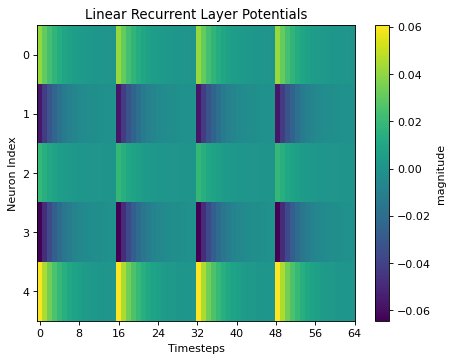

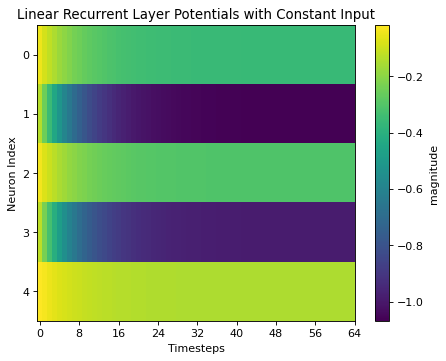

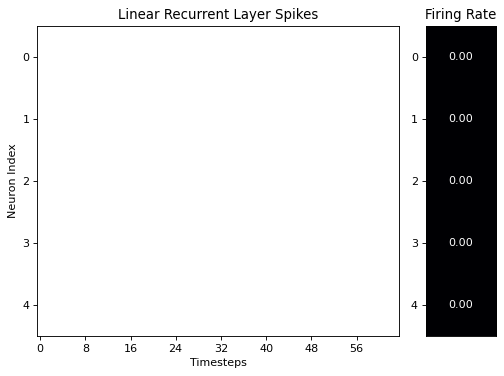

In [20]:
T = 64
lin1_voltages = []
lin2_voltages = []
lin2_spikes = []

lin_recurrent_lif1.reset()
lin_recurrent_lif2.reset()

with torch.no_grad():
  for t in range(T):
    if t % math.floor(T/4) == 0:
      lin_recurrent_lif1(single_stimulus)
    else:
      lin_recurrent_lif1(zero_stimulus)
    lin1_voltages.append(lin_recurrent_lif1.sub_module.v)

    lin2_spikes.append(lin_recurrent_lif2(single_stimulus * 4))
    lin2_voltages.append(lin_recurrent_lif2.sub_module.v)

  lin1_voltages = torch.cat(lin1_voltages)
  lin2_voltages = torch.cat(lin2_voltages)
  lin2_spikes = torch.cat(lin2_spikes).numpy()

  visualizing.plot_2d_heatmap(array=lin1_voltages, title='Linear Recurrent Layer Potentials', xlabel='Timesteps', ylabel='Neuron Index', int_x_ticks=True, x_max=T, dpi=80)
  visualizing.plot_2d_heatmap(array=lin2_voltages, title='Linear Recurrent Layer Potentials with Constant Input', xlabel='Timesteps', ylabel='Neuron Index', int_x_ticks=True, x_max=T, dpi=80)
  visualizing.plot_1d_spikes(spikes=lin2_spikes, title='Linear Recurrent Layer Spikes', xlabel='Timesteps', ylabel='Neuron Index', int_x_ticks=True, dpi=80)
 
  print(f'Weights of Linear Recurrent Layer 1:\n{lin_recurrent_lif1.rc.weight.numpy().round(decimals=3)}')
  print(f'Weights of Linear Recurrent Layer 2:\n{lin_recurrent_lif2.rc.weight.numpy().round(decimals=3)}')

We can see that there is a constant weight matrix that reaches a steady state very quickly.

The stimulus on the constant input is high enough that we do have some spiking behavior, given the stochastic initial conditions of the neurons allows for this.

# MNIST with SNN
Using spiking LIF neurons and recurrent layers to classify the MNIST handwritten numbers dataset

In [21]:
transform = transforms.Compose([
  transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [22]:
print(len(mnist_trainset))
print(len(mnist_testset))
print(type(mnist_trainset))

im = mnist_trainset[0][0]
print(type(im))

60000
10000
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torch.Tensor'>


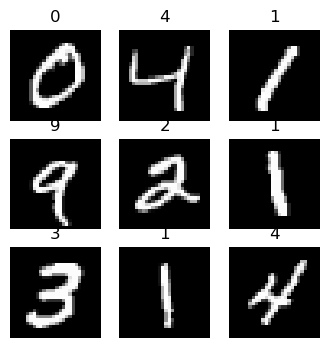

In [23]:
# show some of the numbers/photos
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(4,4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, num = mnist_trainset[i]
    figure.add_subplot(rows, cols, i)
    plt.title(num)
    plt.axis("off")
    plt.imshow(transforms.ToPILImage(mode="L")(img), cmap="gray")
plt.show()

In [24]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(
  dataset=mnist_trainset,
  batch_size=batch_size,
  shuffle=True)
test_loader = torch.utils.data.DataLoader(
  dataset=mnist_testset,
  batch_size=batch_size,
  shuffle=True)

In [25]:
# network architecture
net = nn.Sequential(
  layer.Flatten(), # (28, 28)
  neuron.LIFNode(tau=2., surrogate_function=surrogate.ATan()), # (28*28,)
  layer.Linear(in_features=28*28, out_features=10), # (10,)
)


optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

In [26]:
def train_one_epoch(epoch_index, T):
  running_loss = 0.
  last_loss = 0.
  correct_count = 0
  accuracy = []
  losses = []
  
  functional.reset_net(net)

  for i, data in enumerate(train_loader):
    inputs, labels = data

    optimizer.zero_grad()
    for t in range(T):
      outputs = net(inputs) # if t % 4 == 0 else net(torch.zeros_like(inputs))
      # chunked: T timesteps of one image, no intermediate non-stiumlus
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
    correct_count += (torch.argmax(outputs, dim=1) == labels).sum().item()
    losses.append(loss.item())

    running_loss += loss.item()

    functional.reset_net(net)

    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      running_loss = 0.

    if i % 100 == 99:
      accuracy.append(correct_count / 1000)
      correct_count = 0
  

  return losses, accuracy

In [56]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

training_loss = []
validation_loss = []

training_acc = []
validation_acc = []
total_vcorrect = 0

EPOCHS = 5
T_train = 128
T_val = 16

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # training
    net.train(True)
    losses, epoch_training_acc = train_one_epoch(epoch, T_train)
    training_loss += losses
    training_acc += epoch_training_acc 
    net.train(False)

    # validation
    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        for _ in range(T_val):
            voutputs = net(vinputs)
        # loss
        vloss = loss_fn(voutputs, vlabels).item()
        validation_loss.append(vloss)

        running_vloss += vloss
        # accuracy
        vcorrect = (torch.argmax(voutputs, dim=1) == vlabels).sum().item()
        total_vcorrect += vcorrect
        validation_acc.append(vcorrect / batch_size)

        functional.reset_net(net[1])

    avg_loss = sum(losses) / len(losses)
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # training_loss.append(avg_loss)
    # validation_loss.append(avg_vloss)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        # torch.save(net.state_dict(), model_path)

    epoch += 1

EPOCH 1:
  batch 1000 loss: 2.3958609912395477
  batch 2000 loss: 2.401096527099609
  batch 3000 loss: 2.3983356837034226
  batch 4000 loss: 2.3778140581846237
  batch 5000 loss: 2.3972606554031373


KeyboardInterrupt: 

NameError: name 'training_loss' is not defined

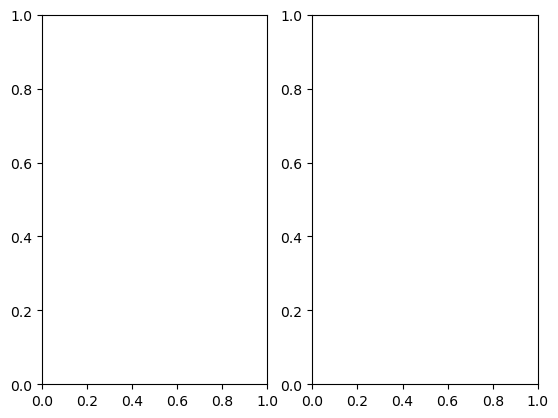

In [27]:
fig, ax = plt.subplots(1, 2)
n = len(training_loss)
ax[0].plot(range(n), training_loss)
ax[0].set_title('Traing Loss (LIF Node, No Recurrent Connections)')

n = len(validation_loss)
ax[1].plot(range(n), validation_loss)
ax[1].set_title('Validation Loss (LIF Node, No Recurrent Connections)')
fig.set_figwidth(12)
plt.show()

NameError: name 'training_acc' is not defined

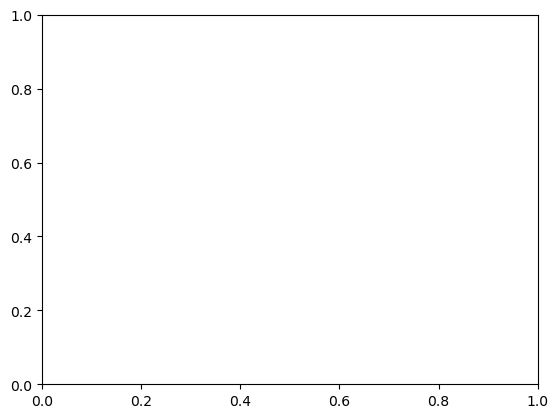

In [ ]:
fig, ax = plt.subplots()
ax.plot(training_acc)
ax.set_title('Training Accuracy (LIF Node, No Recurrent Connections)')
plt.show()

In [78]:
# network architecture
net = nn.Sequential(
  layer.Flatten(), # (28, 28)
  neuron.LIFNode(tau=8., v_threshold=0.9), # (28*28,)
  # layer.Linear(in_features=28*28, out_features=10), # (10,)
)

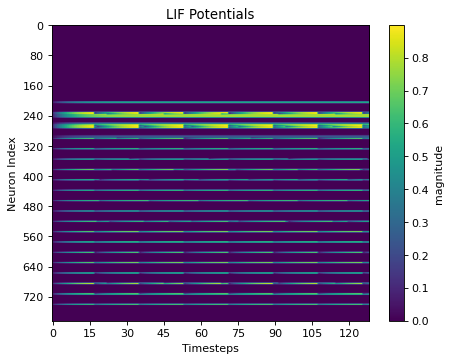

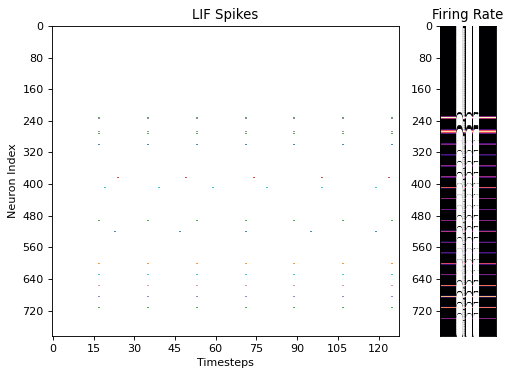

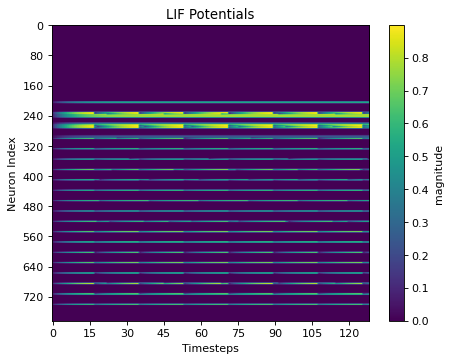

In [79]:
# determine how weights are distributed at LIF node initialization 
# plot stimulus as graph
# check node connectivity (fully-connected vs. one-to-one): one-to-one
# test: present different images 
 
T = 128
potentials = []
spikes = []

functional.reset_net(net)

image, label = mnist_testset[0]

with torch.no_grad():
  for t in range(T):
    spikes.append(net(image))
    potentials.append(net[1].v)

  spikes = torch.cat(spikes).numpy()
  potentials = torch.cat(potentials)

visualizing.plot_1d_spikes(spikes=spikes, title='LIF Spikes', xlabel='Timesteps', ylabel='Neuron Index', int_x_ticks=True, dpi=80)
visualizing.plot_2d_heatmap(array=potentials, title='LIF Potentials', xlabel='Timesteps', ylabel='Neuron Index', int_x_ticks=True, x_max=T, dpi=80)

image shape: torch.Size([28, 28])


<Figure size 640x480 with 0 Axes>

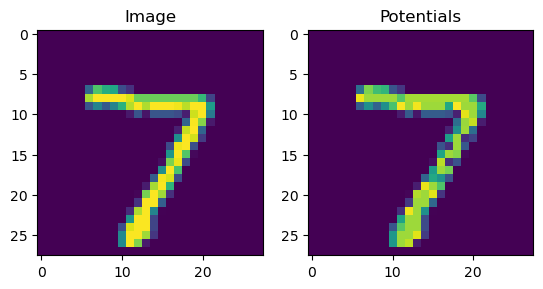

In [74]:
print('image shape:', image.squeeze().shape)
p0 = potentials[100].reshape(image.squeeze().shape)
plt.figure()
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.squeeze())
ax[0].set_title('Image')
ax[1].imshow(p0)
ax[1].set_title('Potentials')
plt.show()

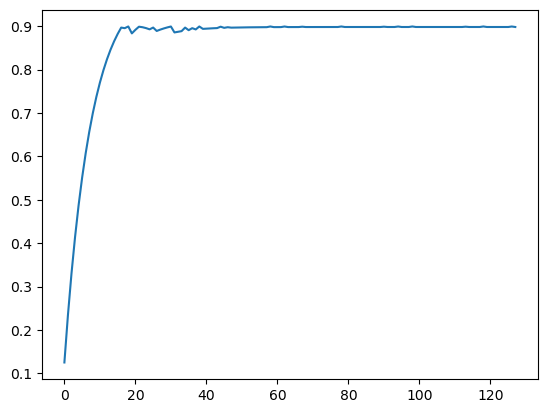

tensor(0.8980)


In [75]:
potentials.shape
maxes = [max(p) for p in potentials]
plt.plot(maxes)
plt.show()
print(max(potentials[-1]))

In [30]:
n = 5
stimulus = torch.zeros(n)
stimulus[math.floor(n / 2)] = 1

T = 16
net = neuron.LIFNode(tau=8., v_threshold=1.0, v_reset=0.0)

potentials = np.zeros((T, n))
spikes = np.zeros((T, n))

functional.reset_net(net)

with torch.no_grad():
  for t in range(T):
    spikes[t, :] = net(stimulus)
    potentials[t, :] = net.v

  # spikes = torch.cat(spikes).numpy()
  # potentials = torch.cat(potentials)

print(spikes.shape, potentials.shape)

(16, 5) (16, 5)


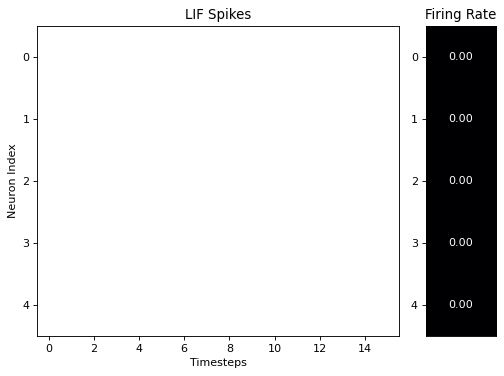

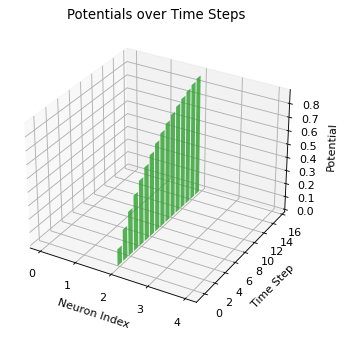

In [31]:
visualizing.plot_1d_spikes(spikes=spikes, title='LIF Spikes', xlabel='Timesteps', ylabel='Neuron Index', int_x_ticks=True, dpi=80)
visualizing.plot_2d_bar_in_3d(array=potentials, title='Potentials over Time Steps', xlabel='Neuron Index', ylabel='Time Step', zlabel='Potential', dpi=80)
plt.show()

NameError: name 'training_acc' is not defined

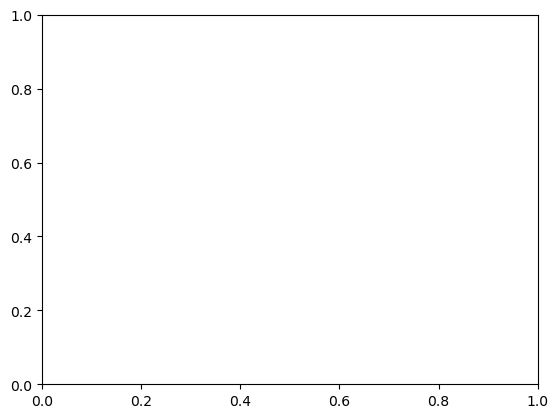

In [32]:
fig, ax = plt.subplots()
ax.plot(training_acc)
ax.set_title('Training Accuracy (IF Node, No Recurrent Connections)')
plt.show()